<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/master/notebooks/python/Lab_PD_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PD Calibration

In this lab we will learn how to estimate the long-run PD after a model has been trained. The PD calibration can be done with the score, the monthly portfolio each case belongs to (usually the behavioural scorecard is used), the labels (Default / Non-Default) and a set of economic factors. For this work we will use an exchange rate and a commodity price.

First, we load the data. It is in Excel, so we use the appropriate function from polars. We require the fastexcel package for that.. There are two worksheets: The first one contains the data for each borrower and each portfolio, and the second one contains the macro factor at each month.

In [1]:
# Install required packages
!pip install fastexcel pwlf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.0 MB/s eta 0:00:00


In [82]:
# Package load
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Date management
from datetime import date
from dateutil.relativedelta import *

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn.metrics import roc_curve, roc_auc_score

# Piecewise functions
import pwlf

# Time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Bigger and prettier plots
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

In [83]:
# Download Excel file
!gdown 'https://drive.google.com/uc?id=1UYmgsu5gI5U_VbraKXHxWTXyZSbM6q5S'

Downloading...
From: https://drive.google.com/uc?id=1UYmgsu5gI5U_VbraKXHxWTXyZSbM6q5S
To: /content/PDCalExample.xlsx
100% 243k/243k [00:00<00:00, 92.5MB/s]


In [84]:
# Load the data. Two datasets are necessary.
loans = pl.read_excel('PDCalExample.xlsx', # Filename
                      sheet_id=1,         # Worksheet index. 0 means "return a dictionary with all".
                      )

econ_factors = pl.read_excel('PDCalExample.xlsx', # Filename
                             sheet_id=2,          # Worksheet index. 0 means "return a dictionary with all".
                             )

In [85]:
loans.describe()

statistic,Portfolio,Default,Probs
str,f64,f64,f64
"""count""",8692.0,8692.0,8692.0
"""null_count""",0.0,0.0,0.0
"""mean""",54.051427,0.064082,0.349971
"""std""",31.922776,0.244913,0.259618
"""min""",1.0,0.0,0.000373
"""25%""",26.0,0.0,0.124056
"""50%""",54.0,0.0,0.304192
"""75%""",82.0,0.0,0.539703
"""max""",108.0,1.0,0.979051


In [86]:
econ_factors.describe()

statistic,Portfolio,Commodity,ExchangeRate
str,f64,f64,f64
"""count""",108.0,108.0,108.0
"""null_count""",0.0,0.0,0.0
"""mean""",54.5,2.2097e6,589.928148
"""std""",31.32092,1.1605e6,76.351437
"""min""",1.0,743331.8,437.08
"""25%""",28.0,1.140213e6,526.48
"""50%""",55.0,1.970861e6,577.85
"""75%""",81.0,3.371706e6,655.55
"""max""",108.0,4.225879e6,749.25


Let's normalize the economic factors using a z-transform.

In [87]:
# Create the column transformer
scaler = StandardScaler()

econ_factors = scaler.fit_transform(econ_factors)
econ_factors = pl.DataFrame(econ_factors)
econ_factors.columns = ['Portfolio', 'Exchange', 'Commodity']
econ_factors.describe()

statistic,Portfolio,Exchange,Commodity
str,f64,f64,f64
"""count""",108.0,108.0,108.0
"""null_count""",0.0,0.0,0.0
"""mean""",-1.3981e-16,2.4466e-16,3.2895e-16
"""std""",1.004662,1.004662,1.004662
"""min""",-1.716087,-1.269424,-2.011236
"""25%""",-0.850024,-0.925852,-0.834876
"""50%""",0.016038,-0.206776,-0.158929
"""75%""",0.850024,1.005909,0.863478
"""max""",1.716087,1.74535,2.096419


## Defining Ratings

We have all the data we need. Let's start then by obtaining PD segments. Basel suggests building 7-15 segments. For this, we can use the excellent package [pwlf](https://pypi.org/project/pwlf/). It will allow segmenting a curve using a given number of cuts.

Which curve do we need to segment? The ROC curve!

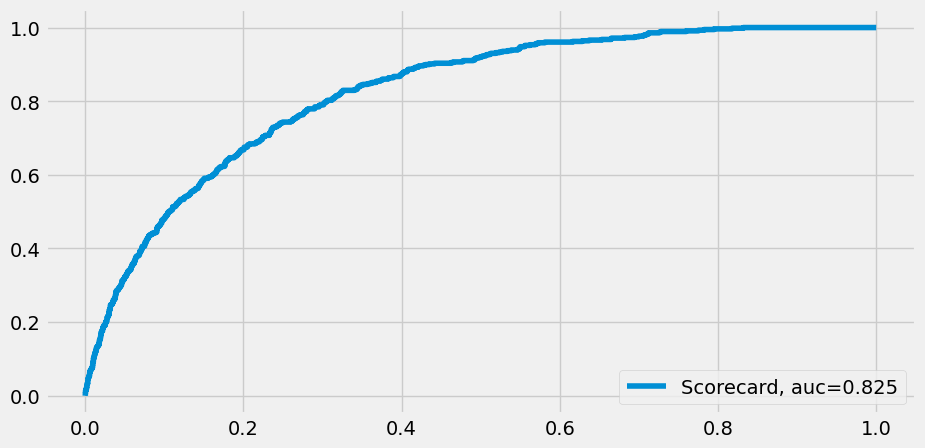

In [88]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(loans['Default'],
                                 loans['Probs'])

# Correct the infinite threshold
thresholds[0] = 1

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = loans['Default'],
                             y_score = loans['Probs']),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Scorecard, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Now we can segment the curve. The process takes a while to run, and sadly it is sequential, so go make yourself a coffee / tea while this runs.

In [89]:
# Define the curve with the ROC curve
piecewise_AUC = pwlf.PiecewiseLinFit(fpr, tpr)

In [90]:
# Calculate the best curve. Long!
nr_cuts = 10
res = piecewise_AUC.fitfast(nr_cuts, pop=2)

As this is a long process, it is a good idea to save the results. The object res can be pickled, or simply the cuts can be saved in a commented line.

In [91]:
res

array([0.        , 0.03567648, 0.09820139, 0.20725598, 0.35070974,
       0.60194519, 0.6185085 , 0.71395248, 0.7275968 , 0.84085931,
       1.        ])

In [92]:
# Use previous result
#res = [0.        , 0.01383389, 0.03920524, 0.07731607, 0.11285577,
#      0.20653665, 0.32339978, 0.41818781, 0.57283343, 0.7999917 ,
#      1.
#      ]

In [93]:
ROC_curve = pd.DataFrame({'fpr': fpr, 'threshold': thresholds})
ROC_curve

,fpr,threshold
0,0.000000,1.000000
1,0.000000,0.979051
2,0.000000,0.978832
3,0.000123,0.977950
4,0.000123,0.975281
...,...,...
941,0.853841,0.064561
942,0.854087,0.064467
943,0.925384,0.019778
944,0.925630,0.019769


To apply the cuts, you can use the method ```fit_with_breaks``` that is available for the ```piecewise_AUC``` object.


In [94]:
# Apply cuts!
cuts = piecewise_AUC.fit_with_breaks(res)

We can now apply this to our dataset and see how the piecewise curve fits the ROC curve.

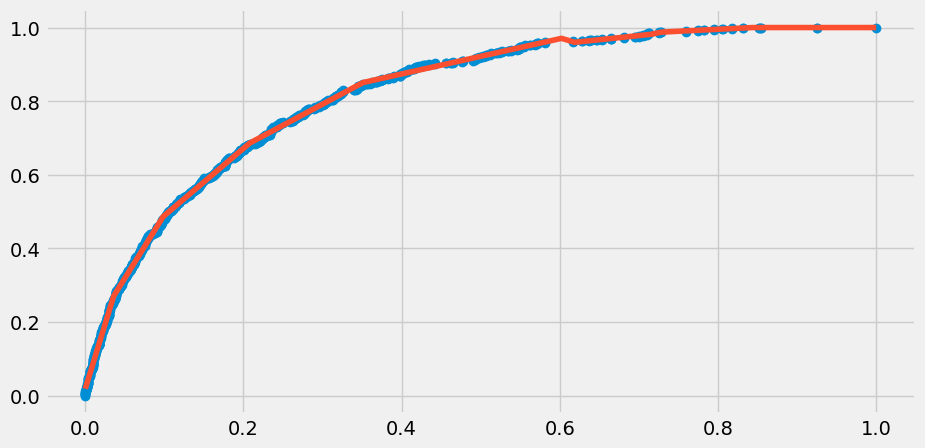

In [95]:
# predict for the determined points
xHat = np.linspace(min(fpr), max(fpr), num=10000)
yHat = piecewise_AUC.predict(xHat)

# plot the results
plt.figure()
plt.plot(fpr, tpr, 'o')
plt.plot(xHat, yHat, '-')
plt.show()

We have a pretty good fit! But we are still not done, we now need to understand if the cuts lead to monotonic PDs. This is the final constraint. For this, we first calculate the PD for the whole dataset (we will adjust this later for each portfolio).

In [96]:
res

array([0.        , 0.03567648, 0.09820139, 0.20725598, 0.35070974,
       0.60194519, 0.6185085 , 0.71395248, 0.7275968 , 0.84085931,
       1.        ])

In [97]:
# Find probability associated with every cut
pbb_cuts = np.zeros_like(res)
i = 0

for fpr in res:
  # Get how far the fpr is from each ROC curve fpr point.
  temp = np.abs(np.round(ROC_curve.fpr, 2) - np.round(fpr, 2))

  # Get the index of the smallest value
  idx = np.argmin(temp)

  # Get the threshold associated with that point
  pbb_cuts[i] = ROC_curve.threshold[idx]
  i += 1

# Reverse to correctly sort
pbb_cuts = np.flip(pbb_cuts)

In [98]:
# Add 0 (and one) if not present. 1 is found, so we don't need to adjust it.
pbb_cuts = np.insert(pbb_cuts, 0, 0)

# Get unique values
pbb_cuts = np.unique(pbb_cuts)

# Display the result
pbb_cuts

array([0.00000000e+00, 3.73070282e-04, 7.60578740e-02, 1.28560136e-01,
       1.41543362e-01, 1.99907596e-01, 2.21645524e-01, 4.04602229e-01,
       5.59415218e-01, 7.24327430e-01, 8.37452376e-01, 1.00000000e+00])

In [99]:
pd_cut = pd.cut(loans['Probs'], pbb_cuts)
pd_cut

[(0.837, 1.0], (0.724, 0.837], (0.837, 1.0], (0.724, 0.837], (0.724, 0.837], ..., (0.559, 0.724], (0.405, 0.559], (0.405, 0.559], (0.405, 0.559], (0.559, 0.724]]
Length: 8692
Categories (11, interval[float64, right]): [(0.0, 0.000373] < (0.000373, 0.0761] < (0.0761, 0.129] <
                                            (0.129, 0.142] ... (0.405, 0.559] < (0.559, 0.724] <
                                            (0.724, 0.837] < (0.837, 1.0]]

And we study the output with a crosstab.

In [100]:
# Create table with cases total.
PDs_Tab = pd.crosstab(pd_cut,
                      loans['Default'],
                      normalize = False)

# Calculate default rate.
pd_final = PDs_Tab[1] / (PDs_Tab[0] + PDs_Tab[1])

# Add the default rate to the PDs_Tab dataframe
PDs_Tab['Default Rate'] = pd_final

# Display the result
PDs_Tab

col_0,0,1,Default Rate
row_0,,,
"(0.0, 0.000373]",1,0,0.000000
"(0.000373, 0.0761]",1367,1,0.000731
"(0.0761, 0.129]",863,7,0.008046
"(0.129, 0.142]",169,5,0.028736
"(0.142, 0.2]",723,9,0.012295
"(0.2, 0.222]",286,1,0.003484
"(0.222, 0.405]",1920,68,0.034205
"(0.405, 0.559]",1135,88,0.071954
"(0.559, 0.724]",898,119,0.117011


There are some monotony breaks. We should combine the cuts that don't make sense, to have a parsimonious curve with sufficient cases and increasing probabilities.  After doing this, our cuts are reasonable and we can now proceed to calculate the PDs for every portfolio. For this, we need to calculate the average number of defaults for each portfolio, over the total number of cases that month.

In [101]:
# Adjusted cuts
pbb_cuts = [0.00000000e+00, 2.21645524e-01, 3.45533938e-01, 4.33724640e-01, 5.72614091e-01,
       7.24327430e-01, 8.37452376e-01, 1.00000000e+00]

# Add the PDCut variable to our dataframe
loans = loans.insert_column(-1,
    pl.Series('PD_Cut', pd.cut(loans['Probs'].to_pandas(), pbb_cuts).astype(str).values)
)

# Create pivot table
PD_monthly = pd.pivot_table(loans.to_pandas(),
                            values = 'Default',
                            index = 'Portfolio',
                            columns = 'PD_Cut',
                            aggfunc = 'mean'
                            )

PD_monthly

PD_Cut,"(0.0, 0.222]","(0.222, 0.346]","(0.346, 0.434]","(0.434, 0.573]","(0.573, 0.724]","(0.724, 0.837]","(0.837, 1.0]"
Portfolio,,,,,,,
1,0.031250,0.071429,0.000000,0.071429,0.083333,0.133333,0.272727
2,0.000000,0.076923,0.142857,0.000000,0.000000,0.285714,0.555556
3,0.000000,0.133333,0.000000,0.142857,0.153846,0.416667,0.444444
4,0.000000,0.000000,0.117647,0.166667,0.166667,0.125000,0.700000
5,0.000000,0.000000,0.090909,0.111111,0.136364,0.250000,0.222222
...,...,...,...,...,...,...,...
104,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,1.000000
105,0.057143,0.000000,0.125000,0.071429,0.166667,0.200000,0.000000
106,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.666667


Now we have calculated the PDs for all ratings! We ended up with one less than the Basel recommendation, but this is only because we have very few loans in this toy example. On larger portfolios you will easily reach the 7-15 range.

Let's plot how our ratings look like.

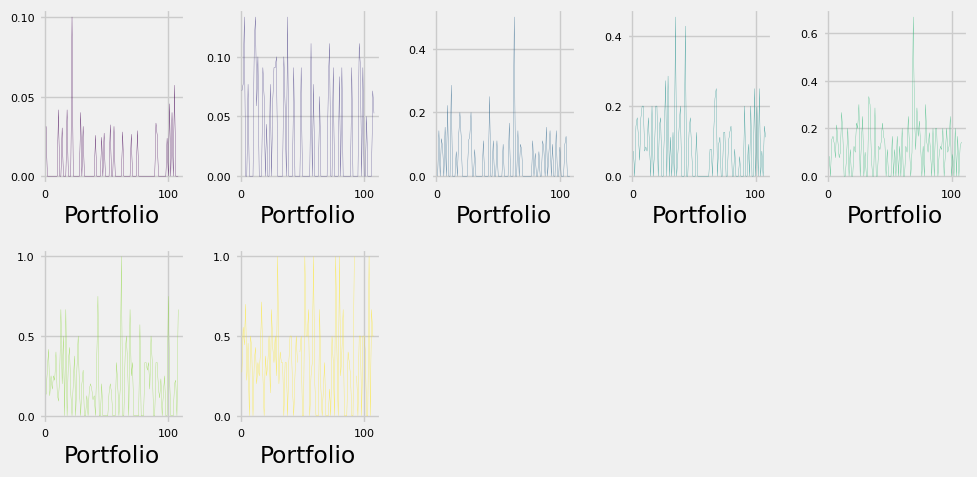

In [102]:
PD_monthly.plot(subplots=True,
          layout=(2, 5),
          sharex=False,
          sharey=False,
          colormap='viridis',
         fontsize=8,
         legend=False,
         linewidth=0.2);
plt.tight_layout();

We see that some months have no defaulters. With the very limited data we have that is to be expected, but in large portfolios this will be softer. Alternatively, you can group this in three-months intervals. In general all time series look stationary.

And that's almost it! Now we are ready to calibrate these PDs across the multiple cuts.

## Estimating Long-Term PD

To estimate the long-term PD, we need to estimate what the average PD is given the last PD and the macroeconomic factors. For this, we can use the subpackage [Time Series Analysis](https://www.statsmodels.org/stable/tsa.html#module-statsmodels.tsa) (```tsa```) of the ```statsmodel``` package. We aim to run a SARIMAX model, so we should study stationary properties, seasonality, etc.

The first step is to turn the Portfolio index into a TimeSeries index. This way Python knows it is dealing with dates. Our data starts in January 1999 and it is monthly data. We arbitrarily set our first day as the 1st of January 1999 and add up from there.

In [103]:
econ_factors

Portfolio,Exchange,Commodity
f64,f64,f64
-1.716087,-1.052045,-0.947117
-1.68401,-1.096854,-1.150414
-1.651934,-1.07226,-1.140545
-1.619858,-1.101046,-0.982644
-1.587781,-1.107534,-0.864219
…,…,…
1.587781,0.32594,-1.01554
1.619858,0.487725,-0.494468
1.651934,0.527082,1.056906


In [105]:
start_date = date(1999, 1, 1)
PD_monthly.index = [pd.to_datetime(start_date + relativedelta(months=portfolio_month -1,  )) for portfolio_month in PD_monthly.index]


In [106]:
PD_monthly.iloc[:, 4]

,"(0.573, 0.724]"
1999-01-01,0.083333
1999-02-01,0.000000
1999-03-01,0.153846
1999-04-01,0.166667
1999-05-01,0.136364
...,...
2007-08-01,0.000000
2007-09-01,0.166667
2007-10-01,0.000000
2007-11-01,0.125000


Now we can decompose our time series to see what is happening.



In [108]:
PD_monthly.index.freq = 'MS'
PD_monthly.index

DatetimeIndex(['1999-01-01', '1999-02-01', '1999-03-01', '1999-04-01',
               '1999-05-01', '1999-06-01', '1999-07-01', '1999-08-01',
               '1999-09-01', '1999-10-01',
               ...
               '2007-03-01', '2007-04-01', '2007-05-01', '2007-06-01',
               '2007-07-01', '2007-08-01', '2007-09-01', '2007-10-01',
               '2007-11-01', '2007-12-01'],
              dtype='datetime64[ns]', length=108, freq='MS')

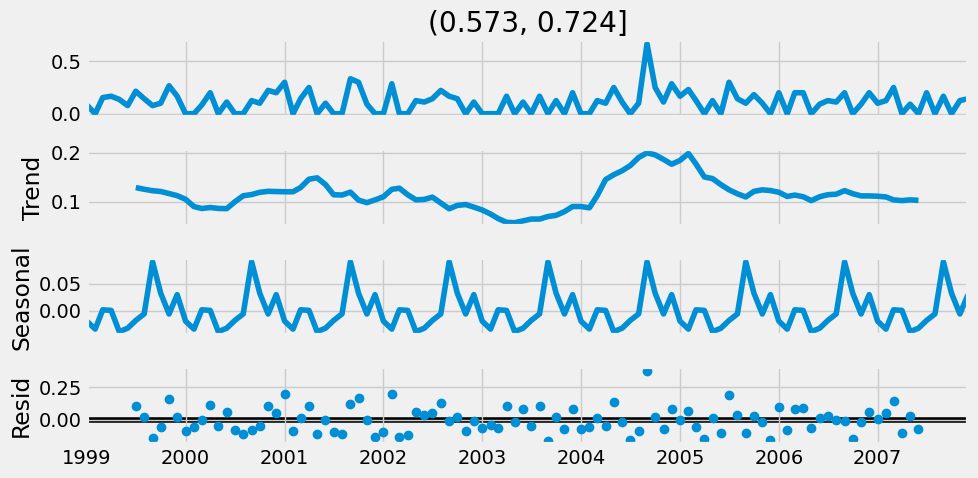

In [109]:
decomposition = seasonal_decompose(PD_monthly.iloc[:, 4], model='additive')
fig = decomposition.plot()
plt.show()

The time series look fairly stationary, with yearly seasonality. We are read to estimate a model!

Within the ```tsa``` package, the [SARIMAX model](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#statsmodels.tsa.statespace.sarimax.SARIMAX), present in the subpackage ```statespace```, is the most general model available, allowing for Seasonality, Auto Regression, Integration, Moving Averages, and eXogenous factors. We will train a simpler ARX model (autoregressive with exogenous regressors), but you are welcome to experiment further, more complex, regressions.

Let's search for the best model for a rating, searching between 1 and 6 autoregression factors, using the macroeconomic factors as the exogenous variables.

In [110]:
# Define the search space.
p = range(1, 6)
d = range(0, 2)
q = range(0, 2)

# Create an interative list of ps, ds, qs.
from itertools import product
pdq = list(product(p, d, q))

# Seasonal parameters. One year back.
ps = range(0, 4)
ds = range(0, 1)
qs = range(0, 1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

# Train the models for a series and test multiple values.
y = PD_monthly.iloc[:, 4] # Choose the fifth rating

auc_out = []

for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = SARIMAX(y,
                    exog=np.asarray(econ_factors),
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                    )
      results = mod.fit()
      auc_out.append([param, param_seasonal, results.aic])
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

# Nicer formatting
auc_out = pd.DataFrame(auc_out,
                       columns = ['(p,q,r)', '(ps, qs, rs, S)', 'AIC'])

ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-119.81654566764666
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-109.68565923958494
ARIMA(1, 0, 0)x(2, 0, 0, 12)12 - AIC:-105.01697259543143
ARIMA(1, 0, 0)x(3, 0, 0, 12)12 - AIC:-104.78511535307014
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-164.10670596142032
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-138.78741652466638
ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:-115.60105525699126
ARIMA(1, 0, 1)x(3, 0, 0, 12)12 - AIC:-108.18780653863395
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-116.70619669538085
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-96.94065177540669
ARIMA(1, 1, 0)x(2, 0, 0, 12)12 - AIC:-78.62126846489602
ARIMA(1, 1, 0)x(3, 0, 0, 12)12 - AIC:-76.47149969850815
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-161.68679820277507
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-136.0986174151367
ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:-114.55828810363607


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(3, 0, 0, 12)12 - AIC:-104.08146235374089
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:-126.83665484304203
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:-107.30427324024681
ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:-101.00935449613272
ARIMA(2, 0, 0)x(3, 0, 0, 12)12 - AIC:-108.52741827025662
ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:-162.59611434431255
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:-135.5533956789047


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:-114.10273978976107


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1)x(3, 0, 0, 12)12 - AIC:-107.62781831134818
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:-128.8729116863558
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:-105.91463658952158
ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:-87.75935256292613
ARIMA(2, 1, 0)x(3, 0, 0, 12)12 - AIC:-84.47764571858588
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:-161.1468607764633
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:-133.3410183610722
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:-111.62377229775527
ARIMA(2, 1, 1)x(3, 0, 0, 12)12 - AIC:-103.70010886634343
ARIMA(3, 0, 0)x(0, 0, 0, 12)12 - AIC:-133.18929467254188
ARIMA(3, 0, 0)x(1, 0, 0, 12)12 - AIC:-110.32149793217806
ARIMA(3, 0, 0)x(2, 0, 0, 12)12 - AIC:-97.32643122460311
ARIMA(3, 0, 0)x(3, 0, 0, 12)12 - AIC:-103.72908535520288


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 1)x(0, 0, 0, 12)12 - AIC:-161.55360379898872


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 1)x(1, 0, 0, 12)12 - AIC:-133.04410170844733


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 1)x(2, 0, 0, 12)12 - AIC:-110.50153775930352


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 1)x(3, 0, 0, 12)12 - AIC:-101.7956910257791
ARIMA(3, 1, 0)x(0, 0, 0, 12)12 - AIC:-137.1514410955903
ARIMA(3, 1, 0)x(1, 0, 0, 12)12 - AIC:-112.55308438139735
ARIMA(3, 1, 0)x(2, 0, 0, 12)12 - AIC:-92.39112110662843
ARIMA(3, 1, 0)x(3, 0, 0, 12)12 - AIC:-92.91997225900626
ARIMA(3, 1, 1)x(0, 0, 0, 12)12 - AIC:-156.71955934922335
ARIMA(3, 1, 1)x(1, 0, 0, 12)12 - AIC:-129.14481106788458
ARIMA(3, 1, 1)x(2, 0, 0, 12)12 - AIC:-107.14030072431878


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(3, 0, 0, 12)12 - AIC:-99.61588409401642
ARIMA(4, 0, 0)x(0, 0, 0, 12)12 - AIC:-139.03328808525555
ARIMA(4, 0, 0)x(1, 0, 0, 12)12 - AIC:-114.64752364934805
ARIMA(4, 0, 0)x(2, 0, 0, 12)12 - AIC:-96.08913780480862


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 0)x(3, 0, 0, 12)12 - AIC:-101.51702559439897


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 1)x(0, 0, 0, 12)12 - AIC:-157.19649669926213


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 1)x(1, 0, 0, 12)12 - AIC:-128.59845860281536


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 1)x(2, 0, 0, 12)12 - AIC:-108.24277540267883


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 1)x(3, 0, 0, 12)12 - AIC:-100.4346507629312
ARIMA(4, 1, 0)x(0, 0, 0, 12)12 - AIC:-141.01385691300447
ARIMA(4, 1, 0)x(1, 0, 0, 12)12 - AIC:-115.60992288205153


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 0)x(2, 0, 0, 12)12 - AIC:-97.15190018913897
ARIMA(4, 1, 0)x(3, 0, 0, 12)12 - AIC:-89.60288073680252
ARIMA(4, 1, 1)x(0, 0, 0, 12)12 - AIC:-152.1837925314097


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 1)x(1, 0, 0, 12)12 - AIC:-126.69178530460118


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 1)x(2, 0, 0, 12)12 - AIC:-106.43875822282715


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 1)x(3, 0, 0, 12)12 - AIC:-95.18692097244018
ARIMA(5, 0, 0)x(0, 0, 0, 12)12 - AIC:-141.7209574914097
ARIMA(5, 0, 0)x(1, 0, 0, 12)12 - AIC:-116.17159540793287
ARIMA(5, 0, 0)x(2, 0, 0, 12)12 - AIC:-98.41763666872232


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 0, 0)x(3, 0, 0, 12)12 - AIC:-97.35527785733298


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 0, 1)x(0, 0, 0, 12)12 - AIC:-152.55261550325793


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 0, 1)x(1, 0, 0, 12)12 - AIC:-124.51577608278194


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 0, 1)x(2, 0, 0, 12)12 - AIC:-105.0146831237862


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 0, 1)x(3, 0, 0, 12)12 - AIC:-95.34987517826121
ARIMA(5, 1, 0)x(0, 0, 0, 12)12 - AIC:-139.5220679154465
ARIMA(5, 1, 0)x(1, 0, 0, 12)12 - AIC:-115.00797412409634
ARIMA(5, 1, 0)x(2, 0, 0, 12)12 - AIC:-97.29783663101101
ARIMA(5, 1, 0)x(3, 0, 0, 12)12 - AIC:-88.54424069440242
ARIMA(5, 1, 1)x(0, 0, 0, 12)12 - AIC:-147.98532401947534


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 1, 1)x(1, 0, 0, 12)12 - AIC:-121.61964045963592


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 1, 1)x(2, 0, 0, 12)12 - AIC:-101.64101706648921
ARIMA(5, 1, 1)x(3, 0, 0, 12)12 - AIC:-91.54992501066768


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


There are a few models that did not converge. Always remember to adjust the iterations so that the models are correctly estimated!

Let's see which one is the resulting model. AIC should be minimized.

In [111]:
auc_out.sort_values(by='AIC', ascending=True)

,"(p,q,r)","(ps, qs, rs, S)",AIC
4,"(1, 0, 1)","(0, 0, 0, 12)",-164.106706
20,"(2, 0, 1)","(0, 0, 0, 12)",-162.596114
12,"(1, 1, 1)","(0, 0, 0, 12)",-161.686798
36,"(3, 0, 1)","(0, 0, 0, 12)",-161.553604
28,"(2, 1, 1)","(0, 0, 0, 12)",-161.146861
...,...,...,...
75,"(5, 1, 0)","(3, 0, 0, 12)",-88.544241
26,"(2, 1, 0)","(2, 0, 0, 12)",-87.759353
27,"(2, 1, 0)","(3, 0, 0, 12)",-84.477646
10,"(1, 1, 0)","(2, 0, 0, 12)",-78.621268



We can see from these values that the prefer model is an autoregressive of order 1, with 12 month seasonality.

Let's test the final model for these values.

In [114]:
# ARIMA(1, 1, 1)x(0, 0, 0, 12)12
mod_BB = SARIMAX(y,
              exog=np.asarray(econ_factors),
              order=(1,0,1),
              seasonal_order=(0,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_BB = mod_BB.fit()

print(results_BB.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0164      0.042      0.394      0.694      -0.065       0.098
x2             0.0567      0.020      2.788      0.005       0.017       0.096
x3             0.0115      0.018      0.649      0.516      -0.023       0.046
ar.L1          0.9833      0.012     83.427      0.000       0.960       1.006
ma.L1         -1.0000    217.799     -0.005      0.996    -427.879     425.879
sigma2         0.0106      2.316      0.005      0.996      -4.530       4.551


In [115]:
# ARIMA(2, 0, 1)x(0, 0, 0, 12)12
mod_BB = SARIMAX(y,
              exog=np.asarray(econ_factors),
              order=(2,0,1),
              seasonal_order=(0,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_BB = mod_BB.fit()

print(results_BB.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0153      0.041      0.373      0.709      -0.065       0.095
x2             0.0567      0.019      2.946      0.003       0.019       0.094
x3             0.0114      0.017      0.667      0.505      -0.022       0.045
ar.L1          0.9158      0.104      8.766      0.000       0.711       1.121
ar.L2          0.0668      0.103      0.649      0.516      -0.135       0.268
ma.L1         -1.0000    540.650     -0.002      0.999   -1060.655    1058.655
sigma2         0.0106      5.724      0.002      0.999     -11.208      11.230


We pick the one that **minimizes** the AIC, which is ARIMA(1, 0, 1)x(0, 0, 0, 12).



In [117]:
# ARIMA(1, 0, 1)x(0, 0, 0, 12)12
mod_BB = SARIMAX(y,
              exog=np.asarray(econ_factors),
              order=(1,0,1),
              seasonal_order=(0,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_BB = mod_BB.fit()

print(results_BB.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0164      0.042      0.394      0.694      -0.065       0.098
x2             0.0567      0.020      2.788      0.005       0.017       0.096
x3             0.0115      0.018      0.649      0.516      -0.023       0.046
ar.L1          0.9833      0.012     83.427      0.000       0.960       1.006
ma.L1         -1.0000    217.799     -0.005      0.996    -427.879     425.879
sigma2         0.0106      2.316      0.005      0.996      -4.530       4.551


The results show what, for this dataset, there is not much exogenous information that is useful, except for x2. This would mean we need to go look for better economic factors! Another interesting result is that the ma.L1 and sigma parameters are not useful either, which means that it is the ar.L1 that carries the information.

It is not perfect, so we should be a bit careful with this model and possibly study more complex structures. I leave this as an exercise!

And that's it! Repeating this process for every time series leads to our calibrated PDs. Now what we would do is to use the long-run estimates for the economic factors to reach a long-term PD.

For LGD, the process is the same. The only difference is that you need to use the **downturn** economic factors instead of the long-run economic factors